In [12]:
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from shapely.geometry import Point
from pyproj import Transformer
import contextily as ctx

# These are the unedited, imported methods from orbit_plot.py
from asp_plot.orbit_plot import read_positions_rotations, read_angles, poly_fit

## Notes / TODOs

A few quick thoughts:

> The “Frame Index” and “frame” is not really applicable to the linescan models - it’s a holdover from the SkySat test data and simulations used to originally develop the orbit_plot tool.  If we can relate this back to the original L1B line numbers, that would be ideal.  Should be able to do this with pretty easily with metadata embedded in CSM.
> I’m trying to figure out the Antarctica example, and the 0 diff values around the frame index ~600-1200 that actually changed.  I think some of these are “anchor points”

Should be a way to back this out from CSM model, which has some sampling rate. If we can figure that out we can map the position sample to a line number. Need to email Oleg. Also need to figure out how to chop off start and end, non-imaging positions.

> It’s nice to have plots for each component of position and angle difference, but I also think we want two-panel “summary” plots of the total magnitude of position and angle diff vectors.  So, for example, the position difference magnitude plot with colors for sqrt(dx^2, dy^2, dz^2) values

WIP; TODO: Oleg check math on these magnitudes. TODO: Oleg; what CRS should we use for x,y,z position differences? ECEF, UTM, NED?

> I think we can just show Original values and diff plots, for both the position and angles.  The Original vs. Optimized plots look essentially the same.  So 9 panel fig, with the following for orientation.  And another 9 panel figure with corresponding values for position.

> We will need to discuss options for y axes and color bar ranges, and if/how to handle the original xyz values (big and not intuitive).  The residual plots we’ve been using from orbit_plot also removed a linear fit, I believe

> Yes the residual plots for the angles do use a linear fit removal, and the suggestion to just having the plot of original values and difference is also a good one

## Methods for extraction and plotting

In [25]:
def reproject_ecef(positions, to_epsg=4326):
    transformer = Transformer.from_crs("EPSG:4978", f"EPSG:{to_epsg}")
    x, y, z = transformer.transform(positions[:, 0], positions[:, 1], positions[:, 2])
    return np.column_stack((x, y, z))

def get_orbit_plot_gdf(original_camera, optimized_camera, map_crs, subtract_line_fit=False):
    """
    Get a GeoDataFrame for plotting the difference between the original and optimized camera positions and rotations.
    Methods largely taken from orbit_plot.py in StereoPipeline, but modified to return the data we want for plotting.
    """
    # orbit_plot.py method to get angles in NED
    # https://github.com/NeoGeographyToolkit/StereoPipeline/blob/master/src/asp/Tools/orbit_plot.py#L412
    # This method already calls read_positions_rotations below, but it 
    # doesn't return the positions and rotations we want for plotting
    original_rotation_angles, optimized_rotation_angles = read_angles([original_camera], [optimized_camera], [])

    # orbit_plot.py method to get positions and rotations
    # https://github.com/NeoGeographyToolkit/StereoPipeline/blob/master/src/asp/Tools/orbit_plot.py#L381
    # Could be retrieved from the above method, by adding to return statement there
    original_positions_ecef, original_rotations = read_positions_rotations([original_camera])
    optimized_positions_ecef, optimized_rotations = read_positions_rotations([optimized_camera])

    # Taken directly from orbit_plot.py
    # https://github.com/NeoGeographyToolkit/StereoPipeline/blob/master/src/asp/Tools/orbit_plot.py#L600-L607
    # "The order is roll, pitch, yaw, as returned by R.from_matrix().as_euler('XYZ',degrees=True)"
    original_roll   = np.array([r[0] for r in original_rotation_angles])
    original_pitch  = np.array([r[1] for r in original_rotation_angles])
    original_yaw    = np.array([r[2] for r in original_rotation_angles])
    optimized_roll  = np.array([r[0] for r in optimized_rotation_angles])
    optimized_pitch = np.array([r[1] for r in optimized_rotation_angles])
    optimized_yaw   = np.array([r[2] for r in optimized_rotation_angles])

    # orbit_plot.py method to optionally subtract line fit to original angles
    # https://github.com/NeoGeographyToolkit/StereoPipeline/blob/master/src/asp/Tools/orbit_plot.py#L610-L623
    if subtract_line_fit:
        fit_original_roll = poly_fit(np.array(range(len(original_roll))), original_roll)
        fit_original_pitch = poly_fit(np.array(range(len(original_pitch))), original_pitch)
        fit_original_yaw = poly_fit(np.array(range(len(original_yaw))), original_yaw)
        original_roll = original_roll - fit_original_roll
        original_pitch = original_pitch - fit_original_pitch
        original_yaw = original_yaw - fit_original_yaw
        optimized_roll = optimized_roll - fit_original_roll
        optimized_pitch = optimized_pitch - fit_original_pitch
        optimized_yaw = optimized_yaw - fit_original_yaw

    # We are interested in the difference between the original and optimized angles
    roll_diff = original_roll - optimized_roll
    pitch_diff = original_pitch - optimized_pitch
    yaw_diff = original_yaw - optimized_yaw

    # Also get angular diff magnitude; TODO: Oleg check this math
    angular_diff_magnitudes = np.sqrt(roll_diff**2 + pitch_diff**2 + yaw_diff**2)

    # Reproject positions from ECEF to map_crs
    original_positions_ecef = np.array(original_positions_ecef)
    optimized_positions_ecef = np.array(optimized_positions_ecef)
    original_positions = reproject_ecef(original_positions_ecef, to_epsg=map_crs)
    optimized_positions = reproject_ecef(optimized_positions_ecef, to_epsg=map_crs)

    # Calculate the difference between the original and optimized positions
    position_diffs = optimized_positions - original_positions
    x_position_diff = position_diffs[:, 0]
    y_position_diff = position_diffs[:, 1]
    z_position_diff = position_diffs[:, 2]

    # Get the magntiude of position difference
    # Below is equivalent to: np.sqrt(x_position_diff**2 + y_position_diff**2 + z_position_diff**2)
    position_diff_magnitudes = np.linalg.norm(position_diffs, axis=1)

    # Build a GeoDataFrame for plotting
    data = {
        "original_positions": [Point(x, y, z) for x, y, z in original_positions],
        "optimized_positions": [Point(x, y, z) for x, y, z in optimized_positions],
        "original_rotations": [r for r in original_rotations],
        "optimized_rotations": [r for r in optimized_rotations],
        "position_diff_magnitude": position_diff_magnitudes,
        "x_position_diff": x_position_diff,
        "y_position_diff": y_position_diff,
        "z_position_diff": z_position_diff,
        "angular_diff_magnitude": angular_diff_magnitudes,
        "original_roll": original_roll,
        "original_pitch": original_pitch,
        "original_yaw": original_yaw,
        "optimized_roll": optimized_roll,
        "optimized_pitch": optimized_pitch,
        "optimized_yaw": optimized_yaw,
        "roll_diff": roll_diff,
        "pitch_diff": pitch_diff,
        "yaw_diff": yaw_diff,
    }
    df = pd.DataFrame(data)
    gdf = gpd.GeoDataFrame(df, geometry="original_positions")
    gdf.set_crs(epsg=map_crs, inplace=True);
    # If we wanted to keep things in ECEF
    # gdf.set_crs(epsg="4978", inplace=True);
    return gdf


In [19]:
def mapview_original_optimized_angles(gdf, title=None, figsize=(15, 5), **ctx_kwargs):
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()

    gdf.plot(column="original_roll", cmap="viridis", markersize=50, legend=True, ax=axes[0])
    axes[0].set_title("Original Roll (deg)")
    ctx.add_basemap(ax=axes[0], **ctx_kwargs)

    gdf.plot(column="original_pitch", cmap="viridis", markersize=50, legend=True, ax=axes[1])
    axes[1].set_title("Original Pitch, (deg)")
    ctx.add_basemap(ax=axes[1], **ctx_kwargs)

    gdf.plot(column="original_yaw", cmap="viridis", markersize=50, legend=True, ax=axes[2])
    axes[2].set_title("Original Yaw (deg)")
    ctx.add_basemap(ax=axes[2], **ctx_kwargs)

    gdf.plot(column="optimized_roll", cmap="viridis", markersize=50, legend=True, ax=axes[3])
    axes[3].set_title("Optimized Roll (deg)")
    ctx.add_basemap(ax=axes[3], **ctx_kwargs)

    gdf.plot(column="optimized_pitch", cmap="viridis", markersize=50, legend=True, ax=axes[4])
    axes[4].set_title("Optimized Pitch, (deg)")
    ctx.add_basemap(ax=axes[4], **ctx_kwargs)

    gdf.plot(column="optimized_yaw", cmap="viridis", markersize=50, legend=True, ax=axes[5])
    axes[5].set_title("Optimized Yaw (deg)")
    ctx.add_basemap(ax=axes[5], **ctx_kwargs)

    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

def mapview_difference_in_positions_and_angles(gdf, title=None, figsize=(15, 5), **ctx_kwargs):
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()

    x_vmax = max(abs(np.percentile(gdf.x_position_diff, 1)), abs(np.percentile(gdf.x_position_diff, 99)))
    y_vmax = max(abs(np.percentile(gdf.y_position_diff, 1)), abs(np.percentile(gdf.y_position_diff, 99)))
    z_vmax = max(abs(np.percentile(gdf.z_position_diff, 1)), abs(np.percentile(gdf.z_position_diff, 99)))
    roll_vmax = max(abs(np.percentile(gdf.roll_diff, 1)), abs(np.percentile(gdf.roll_diff, 99)))
    pitch_vmax = max(abs(np.percentile(gdf.pitch_diff, 1)), abs(np.percentile(gdf.pitch_diff, 99)))
    yaw_vmax = max(abs(np.percentile(gdf.yaw_diff, 1)), abs(np.percentile(gdf.yaw_diff, 99)))

    gdf.plot(column="x_position_diff", cmap="coolwarm", markersize=10, legend=True, ax=axes[0], vmin=-x_vmax, vmax=x_vmax)
    axes[0].set_title("Difference in X position [Easting] (m)")
    ctx.add_basemap(ax=axes[0], **ctx_kwargs)

    gdf.plot(column="y_position_diff", cmap="coolwarm", markersize=10, legend=True, ax=axes[1], vmin=-y_vmax, vmax=y_vmax)
    axes[1].set_title("Difference in Y position [Northing] (m)")
    ctx.add_basemap(ax=axes[1], **ctx_kwargs)

    gdf.plot(column="z_position_diff", cmap="coolwarm", markersize=10, legend=True, ax=axes[2], vmin=-z_vmax, vmax=z_vmax)
    axes[2].set_title("Difference in Z position [Altitude] (m)")
    ctx.add_basemap(ax=axes[2], **ctx_kwargs)

    gdf.plot(column="roll_diff", cmap="coolwarm", markersize=10, legend=True, ax=axes[3], vmin=-roll_vmax, vmax=roll_vmax)
    axes[3].set_title("Difference in Roll (deg)")
    ctx.add_basemap(ax=axes[3], **ctx_kwargs)

    gdf.plot(column="pitch_diff", cmap="coolwarm", markersize=10, legend=True, ax=axes[4], vmin=-pitch_vmax, vmax=pitch_vmax)
    axes[4].set_title("Difference in Pitch (deg)")
    ctx.add_basemap(ax=axes[4], **ctx_kwargs)

    gdf.plot(column="yaw_diff", cmap="coolwarm", markersize=10, legend=True, ax=axes[5], vmin=-yaw_vmax, vmax=yaw_vmax)
    axes[5].set_title("Difference in Yaw (deg)")
    ctx.add_basemap(ax=axes[5], **ctx_kwargs)

    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

def plot_difference_in_positions_and_angles(gdf, title=None):
    frame = np.arange(gdf.shape[0])

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    # Plot differences in x, y, z
    axes[0].plot(frame, gdf.x_position_diff)
    axes[0].set_title("Difference in X position [Easting] (m)")
    axes[0].set_xlabel("Frame Index")
    axes[0].set_ylabel("Difference (m)")

    axes[1].plot(frame, gdf.y_position_diff)
    axes[1].set_title("Difference in Y position [Northing] (m)")
    axes[1].set_xlabel("Frame Index")
    axes[1].set_ylabel("Difference (m)")

    axes[2].plot(frame, gdf.z_position_diff)
    axes[2].set_title("Difference in Z position [Altitude] (m)")
    axes[2].set_xlabel("Frame Index")
    axes[2].set_ylabel("Difference (m)")

    # Plot differences in roll, pitch, yaw
    axes[3].plot(frame, gdf.roll_diff)
    axes[3].set_title("Difference in Roll (deg)")
    axes[3].set_xlabel("Frame Index")
    axes[3].set_ylabel("Roll Difference (deg)")

    axes[4].plot(frame, gdf.pitch_diff)
    axes[4].set_title("Difference in Pitch (deg)")
    axes[4].set_xlabel("Frame Index")
    axes[4].set_ylabel("Pitch Difference (deg)")

    axes[5].plot(frame, gdf.yaw_diff)
    axes[5].set_title("Difference in Yaw (deg)")
    axes[5].set_xlabel("Frame Index")
    axes[5].set_ylabel("Yaw Difference (deg)")

    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

In [16]:
# def summary_plot_two_camera_optimization():
  # TODO

## Jitter optimization for Antarctica

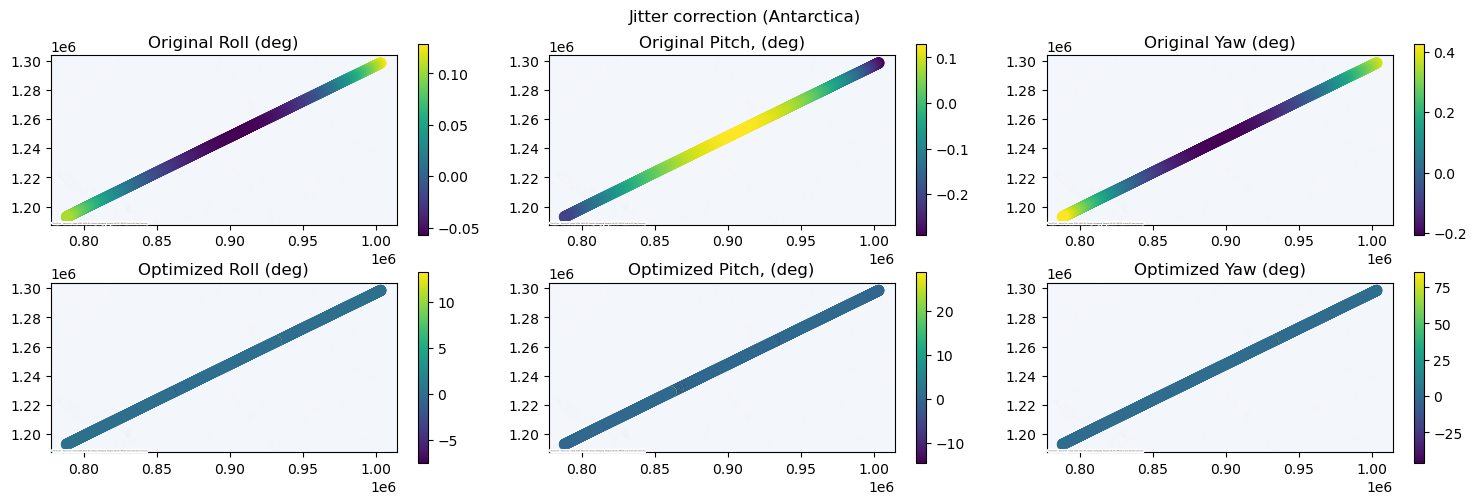

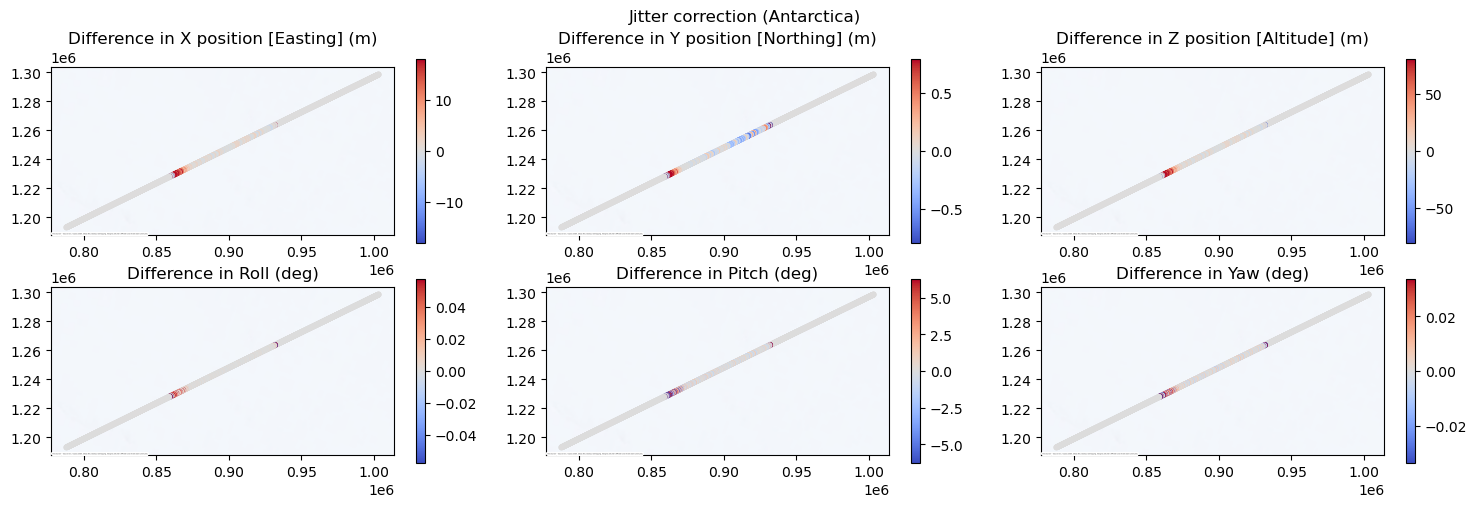

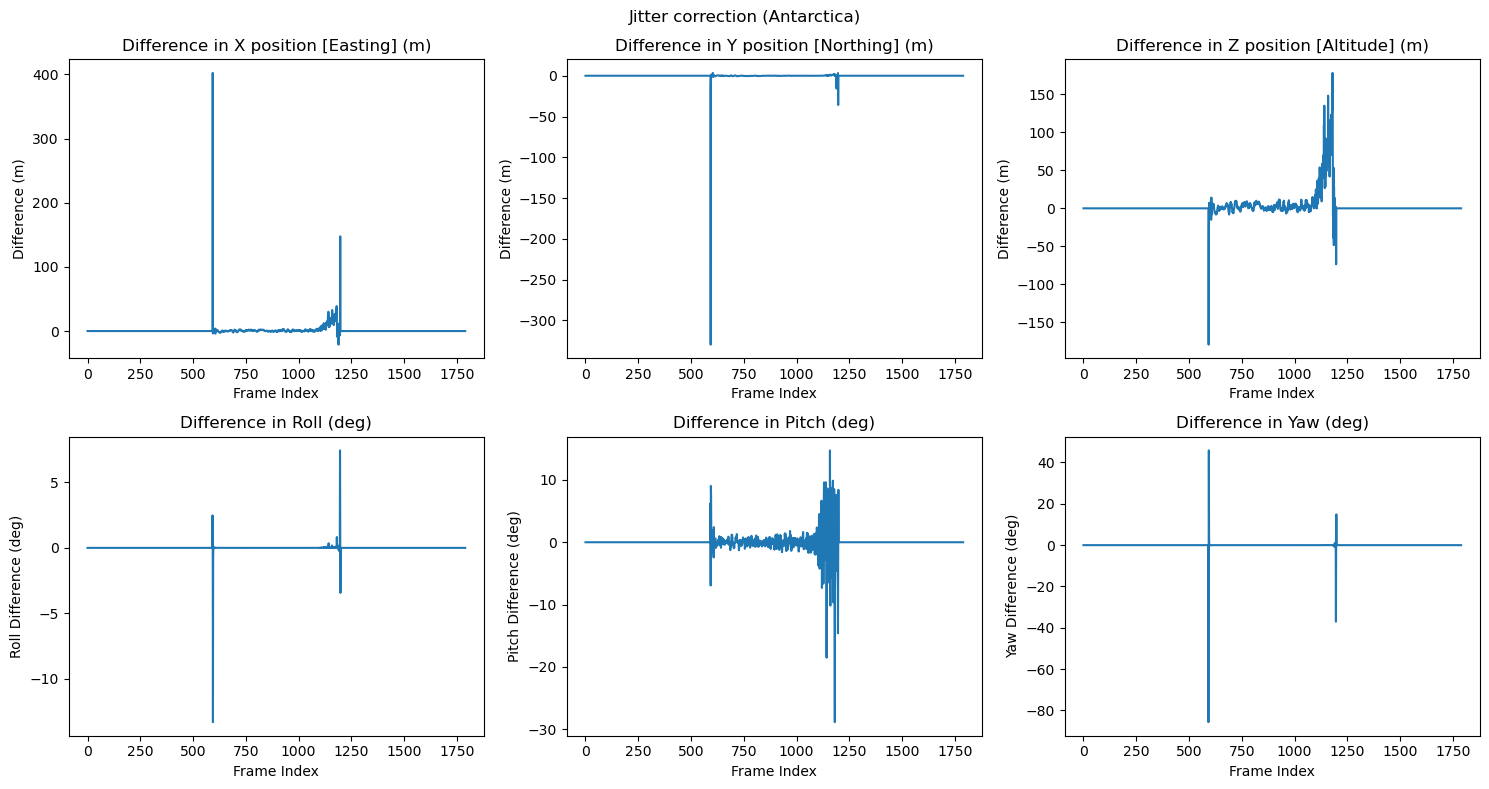

In [26]:
map_crs = "32728" # UTM 28S
title = "Jitter correction (Antarctica)"

original_camera = "../tests/test_data/jitter/csm-10300100A0D00200.r100.adjusted_state.json"
optimized_camera = "../tests/test_data/jitter/jitter_solved_csm-10300100A0D00200.r100.adjusted_state.json"

# alternative, second set of camera files:
# original_camera = "../tests/test_data/jitter/csm-10300100A15E3900.r100.adjusted_state.json"
# optimized_camera = "../tests/test_data/jitter/jitter_solved_csm-10300100A15E3900.r100.adjusted_state.json"

ctx_kwargs = {
    "crs": f"EPSG:{map_crs}",
    "source": ctx.providers.Esri.WorldImagery,
    "attribution_size": 0,
    "alpha": 0.5,
}

# Get the GeoDataFrame for plotting
gdf = get_orbit_plot_gdf(original_camera, optimized_camera, map_crs, subtract_line_fit=True)

# Plot the original and optimized angles
mapview_original_optimized_angles(gdf, title=title, **ctx_kwargs)
mapview_difference_in_positions_and_angles(gdf, title=title, **ctx_kwargs)
plot_difference_in_positions_and_angles(gdf, title=title)

### WIP: Summary plots

In [27]:
map_crs = "32728" # UTM 28S
title = "Jitter correction (Antarctica)"

# first set of cameras
original_camera = "../tests/test_data/jitter/csm-10300100A0D00200.r100.adjusted_state.json"
optimized_camera = "../tests/test_data/jitter/jitter_solved_csm-10300100A0D00200.r100.adjusted_state.json"
gdf_cam1 = get_orbit_plot_gdf(original_camera, optimized_camera, map_crs, subtract_line_fit=True)

# second set of cameras
original_camera = "../tests/test_data/jitter/csm-10300100A15E3900.r100.adjusted_state.json"
optimized_camera = "../tests/test_data/jitter/jitter_solved_csm-10300100A15E3900.r100.adjusted_state.json"
gdf_cam2 = get_orbit_plot_gdf(original_camera, optimized_camera, map_crs, subtract_line_fit=True)

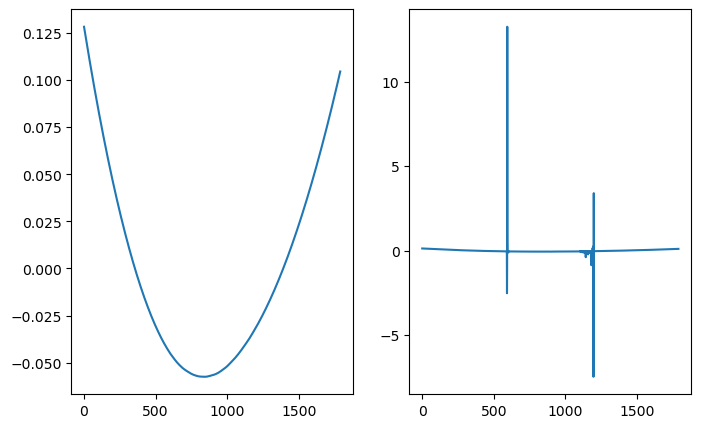

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
axes = axes.flatten()
axes[0].plot(np.arange(gdf_cam1.shape[0]), gdf_cam1.original_roll)
axes[1].plot(np.arange(gdf_cam1.shape[0]), gdf_cam1.optimized_roll)

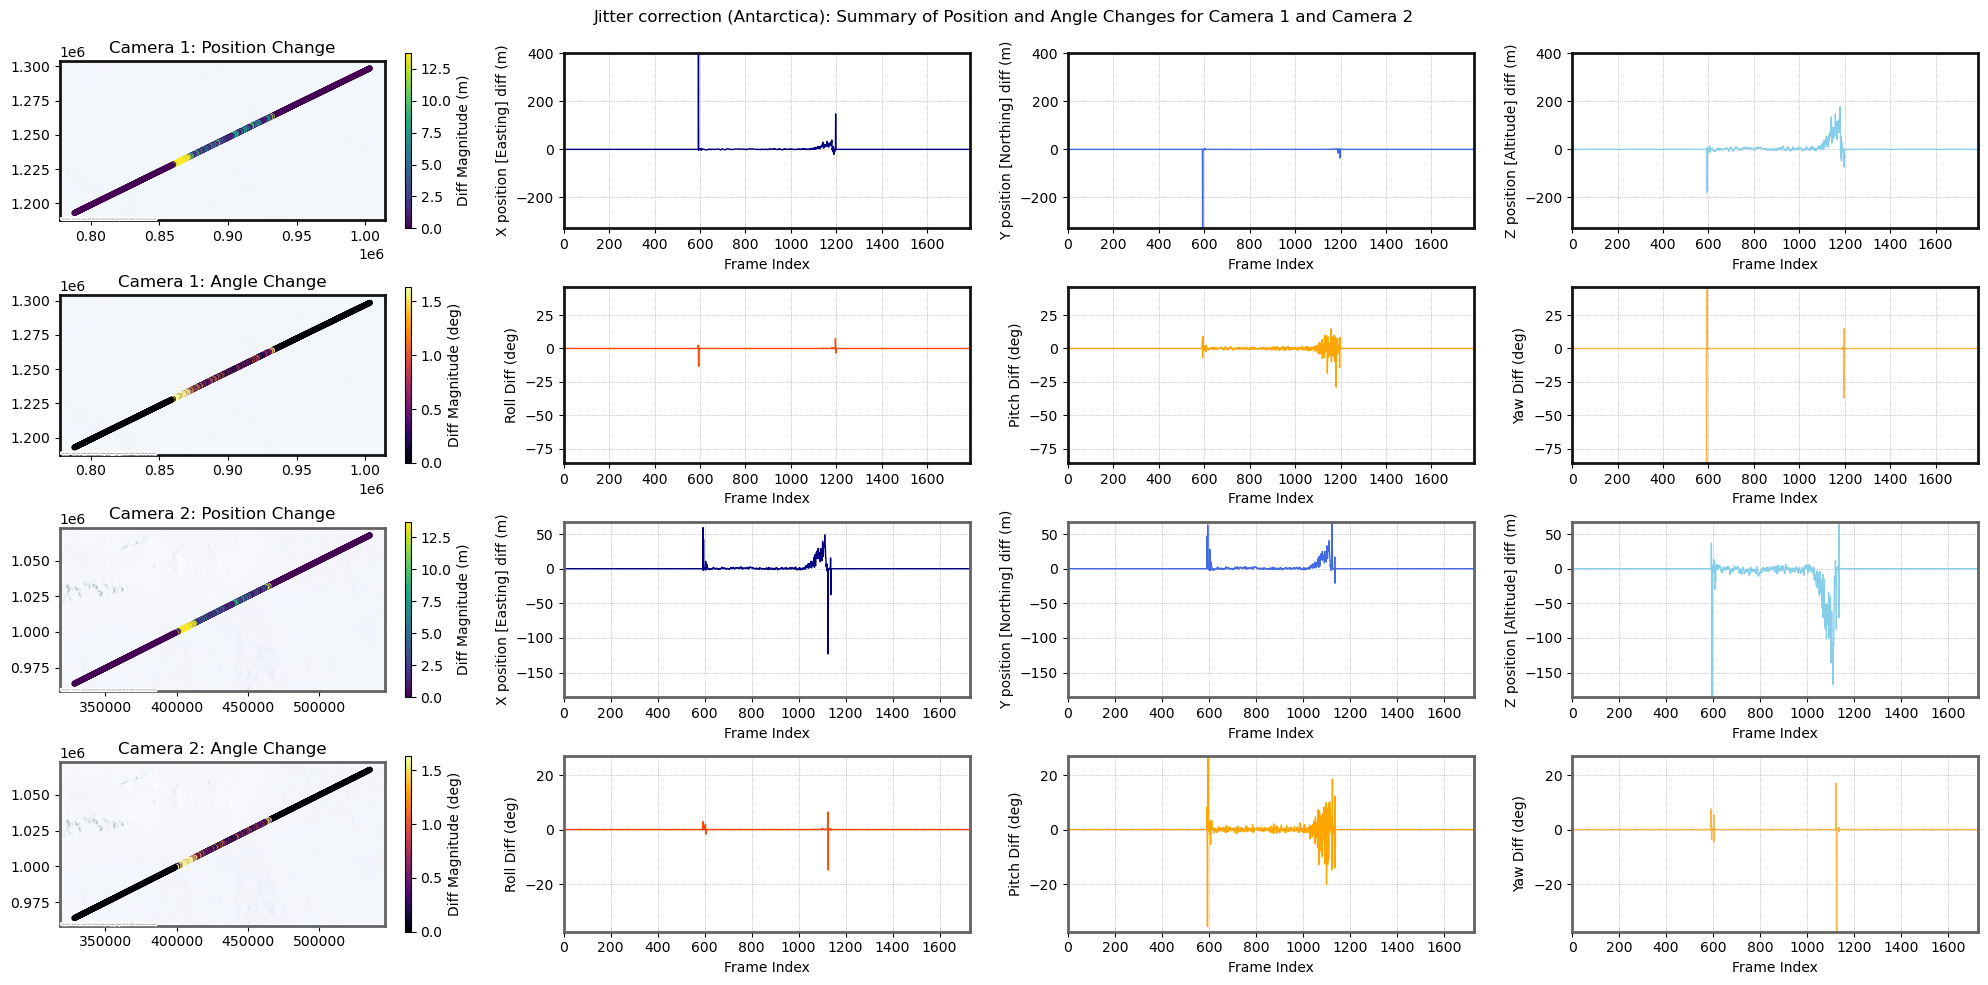

In [29]:
fig, axes = plt.subplots(4, 4, figsize=(20, 10))

# Calculate colorbar ranges
position_values = np.concatenate([gdf_cam1.position_diff_magnitude, gdf_cam2.position_diff_magnitude])
angular_values = np.concatenate([gdf_cam1.angular_diff_magnitude, gdf_cam2.angular_diff_magnitude])

position_vmin, position_vmax = np.percentile(position_values, [0, 95])
angular_vmin, angular_vmax = np.percentile(angular_values, [0, 95])

# Camera 1 mapview plot
ax = axes[0, 0]
im1 = gdf_cam1.plot(ax=ax, column="position_diff_magnitude", cmap="viridis", markersize=10, vmin=position_vmin, vmax=position_vmax, legend=False, label="Camera 1")
ax.set_title("Camera 1: Position Change")
ctx.add_basemap(ax=ax, **ctx_kwargs)
sm1 = ScalarMappable(norm=Normalize(vmin=position_vmin, vmax=position_vmax), cmap="viridis")
cbar1 = plt.colorbar(sm1, ax=ax, orientation="vertical", aspect=30, pad=0.05)
cbar1.set_label("Diff Magnitude (m)")

# Camera 1 angular mapview plot
ax = axes[1, 0]
im3 = gdf_cam1.plot(ax=ax, column="angular_diff_magnitude", cmap="inferno", markersize=10, vmin=angular_vmin, vmax=angular_vmax, legend=False, label="Camera 1")
ax.set_title("Camera 1: Angle Change")
ctx.add_basemap(ax=ax, **ctx_kwargs)
sm3 = ScalarMappable(norm=Normalize(vmin=angular_vmin, vmax=angular_vmax), cmap="inferno")
cbar3 = plt.colorbar(sm3, ax=ax, orientation="vertical", aspect=30, pad=0.05)
cbar3.set_label("Diff Magnitude (deg)")

frame_cam1 = np.arange(gdf_cam1.shape[0])

# Plot diffs in x, y, z for Camera 1
ax1 = axes[0, 1]
ax1.plot(frame_cam1, gdf_cam1.x_position_diff, c="#000080", lw=1)
ax1.set_xlabel("Frame Index")
ax1.set_ylabel("X position [Easting] diff (m)")

ax2 = axes[0, 2]
ax2.plot(frame_cam1, gdf_cam1.y_position_diff, c="#4169E1", lw=1)
ax2.set_xlabel("Frame Index")
ax2.set_ylabel("Y position [Northing] diff (m)")

ax3 = axes[0, 3]
ax3.plot(frame_cam1, gdf_cam1.z_position_diff, c="#87CEEB", lw=1)
ax3.set_xlabel("Frame Index")
ax3.set_ylabel("Z position [Altitude] diff (m)")

# Share y-axis for position diff plots
min_val = min(gdf_cam1.x_position_diff.min(), gdf_cam1.y_position_diff.min(), gdf_cam1.z_position_diff.min())
max_val = max(gdf_cam1.x_position_diff.max(), gdf_cam1.y_position_diff.max(), gdf_cam1.z_position_diff.max())

ax1.set_ylim(min_val, max_val)
ax2.set_ylim(min_val, max_val)
ax3.set_ylim(min_val, max_val)
# ax1.set_yscale('symlog')
# ax2.set_yscale('symlog')
# ax3.set_yscale('symlog')
ax1.set_xlim(frame_cam1.min(), frame_cam1.max())
ax2.set_xlim(frame_cam1.min(), frame_cam1.max())
ax3.set_xlim(frame_cam1.min(), frame_cam1.max())
ax1.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax2.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax3.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")

# Plot diffs in roll, pitch, yaw for Camera 1
ax1 = axes[1, 1]
ax1.plot(frame_cam1, gdf_cam1.roll_diff, c="#FF4500", lw=1)
ax1.set_xlabel("Frame Index")
ax1.set_ylabel("Roll Diff (deg)")

ax2 = axes[1, 2]
ax2.plot(frame_cam1, gdf_cam1.pitch_diff, c="#FFA500", lw=1)
ax2.set_xlabel("Frame Index")
ax2.set_ylabel("Pitch Diff (deg)")

ax3 = axes[1, 3]
ax3.plot(frame_cam1, gdf_cam1.yaw_diff, c="#FFB347", lw=1)
ax3.set_xlabel("Frame Index")
ax3.set_ylabel("Yaw Diff (deg)")

# Share y-axis for angular diff plots
min_val = min(gdf_cam1.roll_diff.min(), gdf_cam1.pitch_diff.min(), gdf_cam1.yaw_diff.min())
max_val = max(gdf_cam1.roll_diff.max(), gdf_cam1.pitch_diff.max(), gdf_cam1.yaw_diff.max())

ax1.set_ylim(min_val, max_val)
ax2.set_ylim(min_val, max_val)
ax3.set_ylim(min_val, max_val)
# ax1.set_yscale('symlog')
# ax2.set_yscale('symlog')
# ax3.set_yscale('symlog')
ax1.set_xlim(frame_cam1.min(), frame_cam1.max())
ax2.set_xlim(frame_cam1.min(), frame_cam1.max())
ax3.set_xlim(frame_cam1.min(), frame_cam1.max())
ax1.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax2.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax3.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")


# Camera 2 mapview plot
ax = axes[2, 0]
im2 = gdf_cam2.plot(ax=ax, column="position_diff_magnitude", cmap="viridis", markersize=10, vmin=position_vmin, vmax=position_vmax, legend=False, label="Camera 2")
ax.set_title("Camera 2: Position Change")
ctx.add_basemap(ax=ax, **ctx_kwargs)
sm2 = ScalarMappable(norm=Normalize(vmin=position_vmin, vmax=position_vmax), cmap="viridis")
cbar2 = plt.colorbar(sm2, ax=ax, orientation="vertical", aspect=30, pad=0.05)
cbar2.set_label("Diff Magnitude (m)")

# Camera 2 angular mapview plot
ax = axes[3, 0]
im4 = gdf_cam2.plot(ax=ax, column="angular_diff_magnitude", cmap="inferno", markersize=10, vmin=angular_vmin, vmax=angular_vmax, legend=False, label="Camera 2")
ax.set_title("Camera 2: Angle Change")
ctx.add_basemap(ax=ax, **ctx_kwargs)
sm4 = ScalarMappable(norm=Normalize(vmin=angular_vmin, vmax=angular_vmax), cmap="inferno")
cbar4 = plt.colorbar(sm4, ax=ax, orientation="vertical", aspect=30, pad=0.05)
cbar4.set_label("Diff Magnitude (deg)")

frame_cam2 = np.arange(gdf_cam2.shape[0])

# Plot diffs in x, y, z for Camera 2
ax1 = axes[2, 1]
ax1.plot(frame_cam2, gdf_cam2.x_position_diff, c="#000080", lw=1)
ax1.set_xlabel("Frame Index")
ax1.set_ylabel("X position [Easting] diff (m)")

ax2 = axes[2, 2]
ax2.plot(frame_cam2, gdf_cam2.y_position_diff, c="#4169E1", lw=1)
ax2.set_xlabel("Frame Index")
ax2.set_ylabel("Y position [Northing] diff (m)")

ax3 = axes[2, 3]
ax3.plot(frame_cam2, gdf_cam2.z_position_diff, c="#87CEEB", lw=1)
ax3.set_xlabel("Frame Index")
ax3.set_ylabel("Z position [Altitude] diff (m)")

# Share y-axis for position diff plots
min_val = min(gdf_cam2.x_position_diff.min(), gdf_cam2.y_position_diff.min(), gdf_cam2.z_position_diff.min())
max_val = max(gdf_cam2.x_position_diff.max(), gdf_cam2.y_position_diff.max(), gdf_cam2.z_position_diff.max())

ax1.set_ylim(min_val, max_val)
ax2.set_ylim(min_val, max_val)
ax3.set_ylim(min_val, max_val)
# ax1.set_yscale('symlog')
# ax2.set_yscale('symlog')
# ax3.set_yscale('symlog')
ax1.set_xlim(frame_cam2.min(), frame_cam2.max())
ax2.set_xlim(frame_cam2.min(), frame_cam2.max())
ax3.set_xlim(frame_cam2.min(), frame_cam2.max())
ax1.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax2.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax3.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")

# Plot diffs in roll, pitch, yaw for Camera 2
ax1 = axes[3, 1]
ax1.plot(frame_cam2, gdf_cam2.roll_diff, c="#FF4500", lw=1)
ax1.set_xlabel("Frame Index")
ax1.set_ylabel("Roll Diff (deg)")

ax2 = axes[3, 2]
ax2.plot(frame_cam2, gdf_cam2.pitch_diff, c="#FFA500", lw=1)
ax2.set_xlabel("Frame Index")
ax2.set_ylabel("Pitch Diff (deg)")

ax3 = axes[3, 3]
ax3.plot(frame_cam2, gdf_cam2.yaw_diff, c="#FFB347", lw=1)
ax3.set_xlabel("Frame Index")
ax3.set_ylabel("Yaw Diff (deg)")

# Share y-axis for angular diff plots
min_val = min(gdf_cam2.roll_diff.min(), gdf_cam2.pitch_diff.min(), gdf_cam2.yaw_diff.min())
max_val = max(gdf_cam2.roll_diff.max(), gdf_cam2.pitch_diff.max(), gdf_cam2.yaw_diff.max())

ax1.set_ylim(min_val, max_val)
ax2.set_ylim(min_val, max_val)
ax3.set_ylim(min_val, max_val)
# ax1.set_yscale('symlog')
# ax2.set_yscale('symlog')
# ax3.set_yscale('symlog')
ax1.set_xlim(frame_cam2.min(), frame_cam2.max())
ax2.set_xlim(frame_cam2.min(), frame_cam2.max())
ax3.set_xlim(frame_cam2.min(), frame_cam2.max())
ax1.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax2.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax3.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")

for ax in axes[:2].flatten():
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('#141414')

for ax in axes[2:].flatten():
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('#636363')

fig.suptitle(f"{title}: Summary of Position and Angle Changes for Camera 1 and Camera 2")

plt.tight_layout()

## More TODOs

- relative to ellipsoid (so not ECEF), plot vector showing XY component of position change and then RdBu colors the vector with Z. Legend of Z RdBu on side with positive / negative range
- more difficult with angle difference. maybe NED vector instead of angles.
- quiver direction can tell us roll and yaw? pitch can be color?

In [ ]:
# from CSM model:
  # "m_nLines": 229023,
  # "m_nSamples": 35180,
  # "m_numPositions": 5370,
  # "m_numQuaternions": 7160,

print("positions: ", gdf.shape[0] * 3) # x, y, z
print("orientations: ", gdf.shape[0] * 4) # quaternion

NameError: name 'gdf' is not defined

## Bundle adjust optimization for Utqiagvik

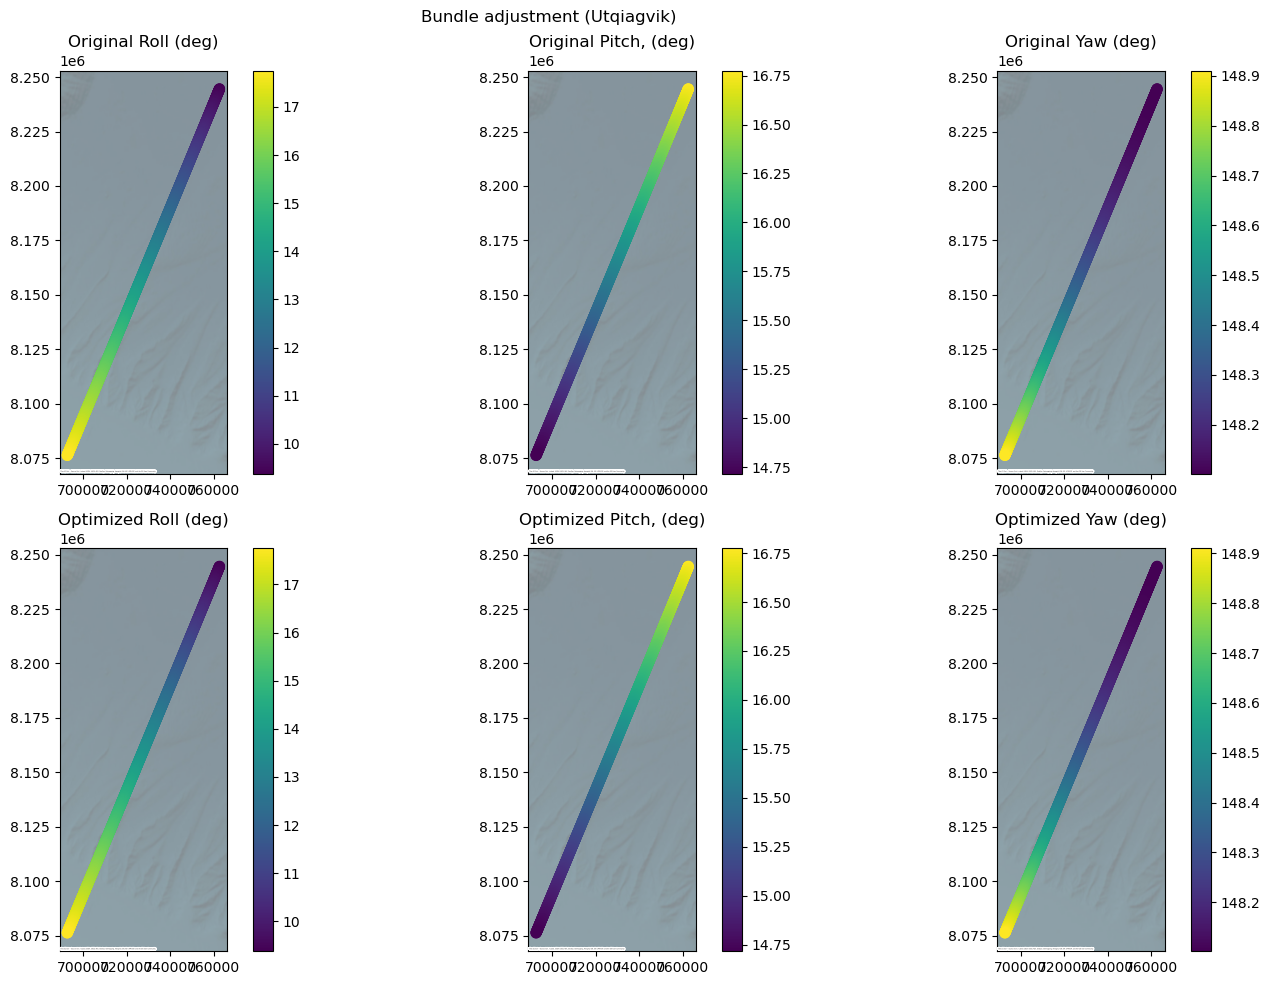

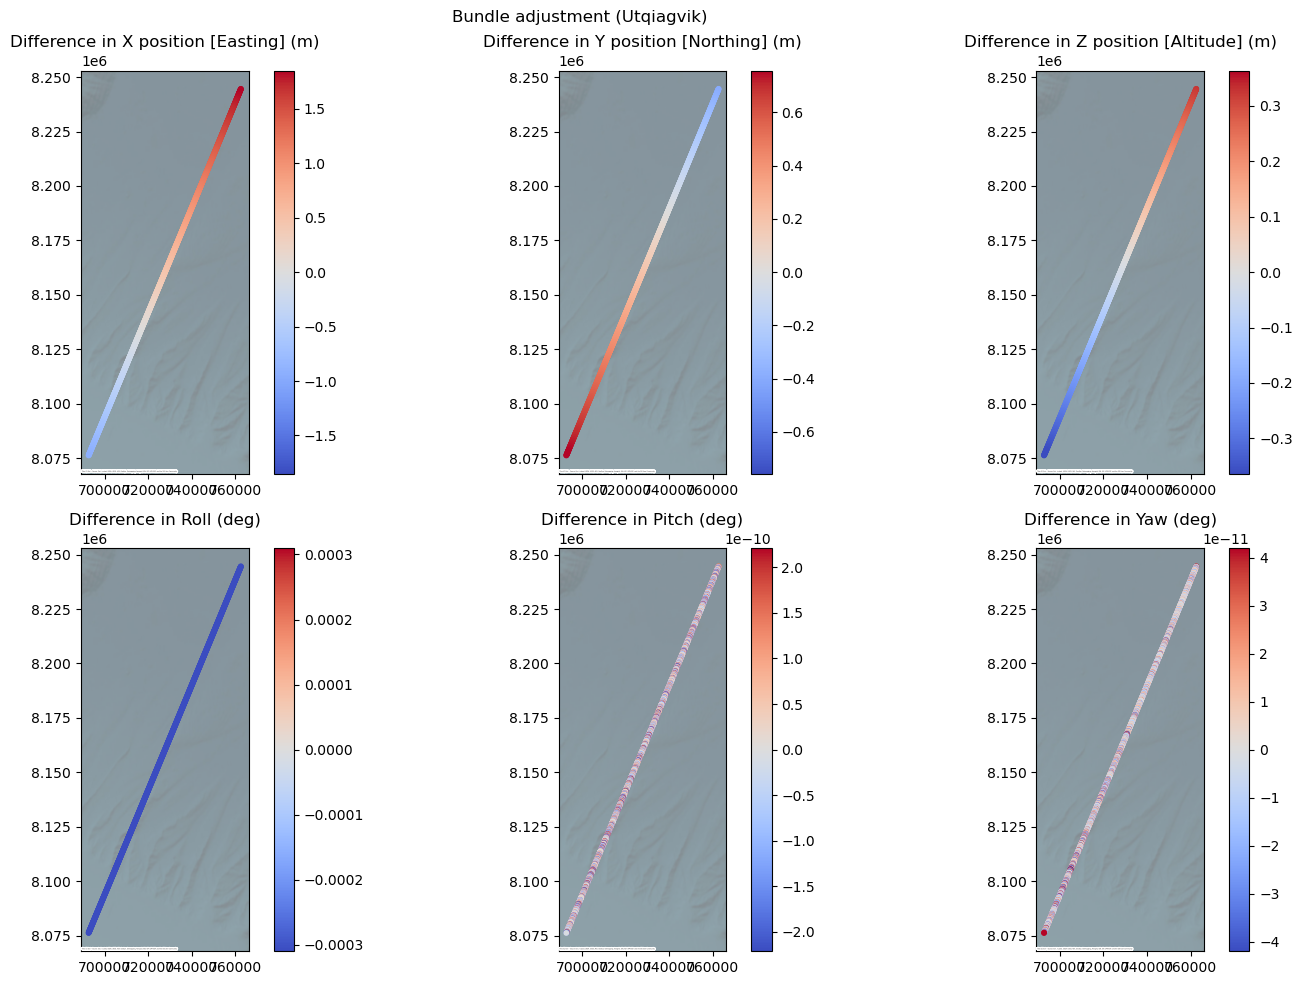

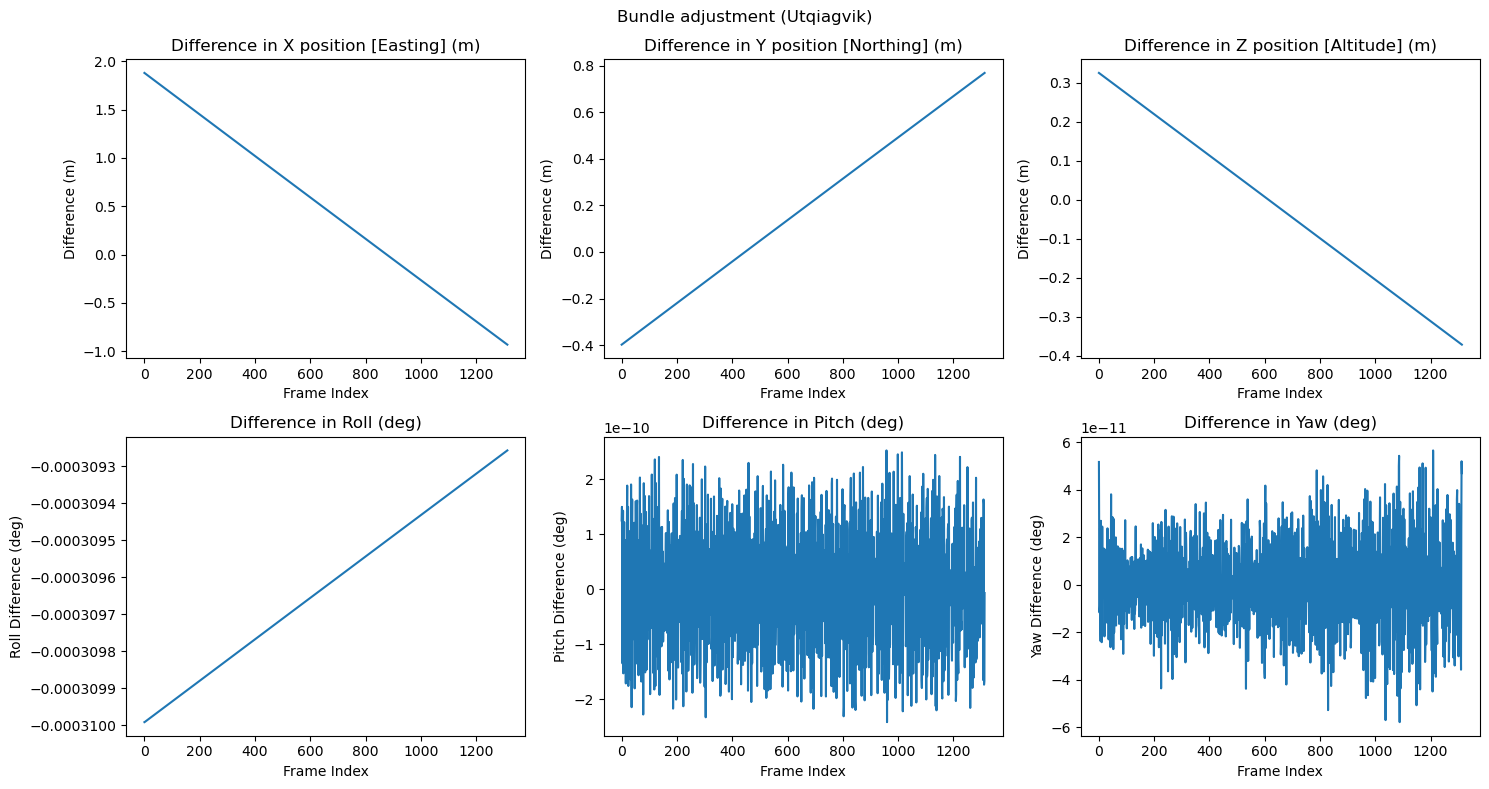

In [11]:
map_crs = "32603" # UTM 3N
title = "Bundle adjustment (Utqiagvik)"

# ba (utqiagvik)
original_camera = "../tests/test_data/ba_cams/1040010075633C00.json"
optimized_camera = "../tests/test_data/ba_cams/1040010075633C00.adjusted_state.json"

# alternative, second set of camera files:
original_camera = "../tests/test_data/ba_cams/1040010074793300.json"
optimized_camera = "../tests/test_data/ba_cams/1040010074793300.adjusted_state.json"

ctx_kwargs = {
    "crs": f"EPSG:{map_crs}",
    "source": ctx.providers.Esri.WorldImagery,
    "attribution_size": 0,
    "alpha": 0.5,
}

# Get the GeoDataFrame for plotting
gdf = get_orbit_plot_gdf(original_camera, optimized_camera, map_crs)

# Plot the original and optimized angles
mapview_original_optimized_angles(gdf, title=title, figsize=(15, 10), **ctx_kwargs)
mapview_difference_in_positions_and_angles(gdf, title=title, figsize=(15, 10), **ctx_kwargs)
plot_difference_in_positions_and_angles(gdf, title=title)

In [ ]:
# TODO: examine this output
# mean of difference should somewhat match:
# cat ~/Dropbox/UW_Shean/WV/2022/WV03_20220417_1040010074793300_1040010075633C00/ba/ba_50ips_10matches_dg_weight_image-1040010074793300.r100.adjust
# 0.31507880581041364 -0.56704003134569203 0.026290020937047243
# 0.99999999996013711 -5.2750283965300539e-07 -4.1355595903483106e-07 -8.9037384989722605e-06

In [6]:
map_crs = "32603" # UTM 3N
title = "Bundle adjustment (Utqiagvik)"

# first set of cameras
original_camera = "../tests/test_data/ba_cams/1040010075633C00.json"
optimized_camera = "../tests/test_data/ba_cams/1040010075633C00.adjusted_state.json"
gdf_cam1 = get_orbit_plot_gdf(original_camera, optimized_camera, map_crs)

# second set of cameras
original_camera = "../tests/test_data/ba_cams/1040010074793300.json"
optimized_camera = "../tests/test_data/ba_cams/1040010074793300.adjusted_state.json"
gdf_cam2 = get_orbit_plot_gdf(original_camera, optimized_camera, map_crs)

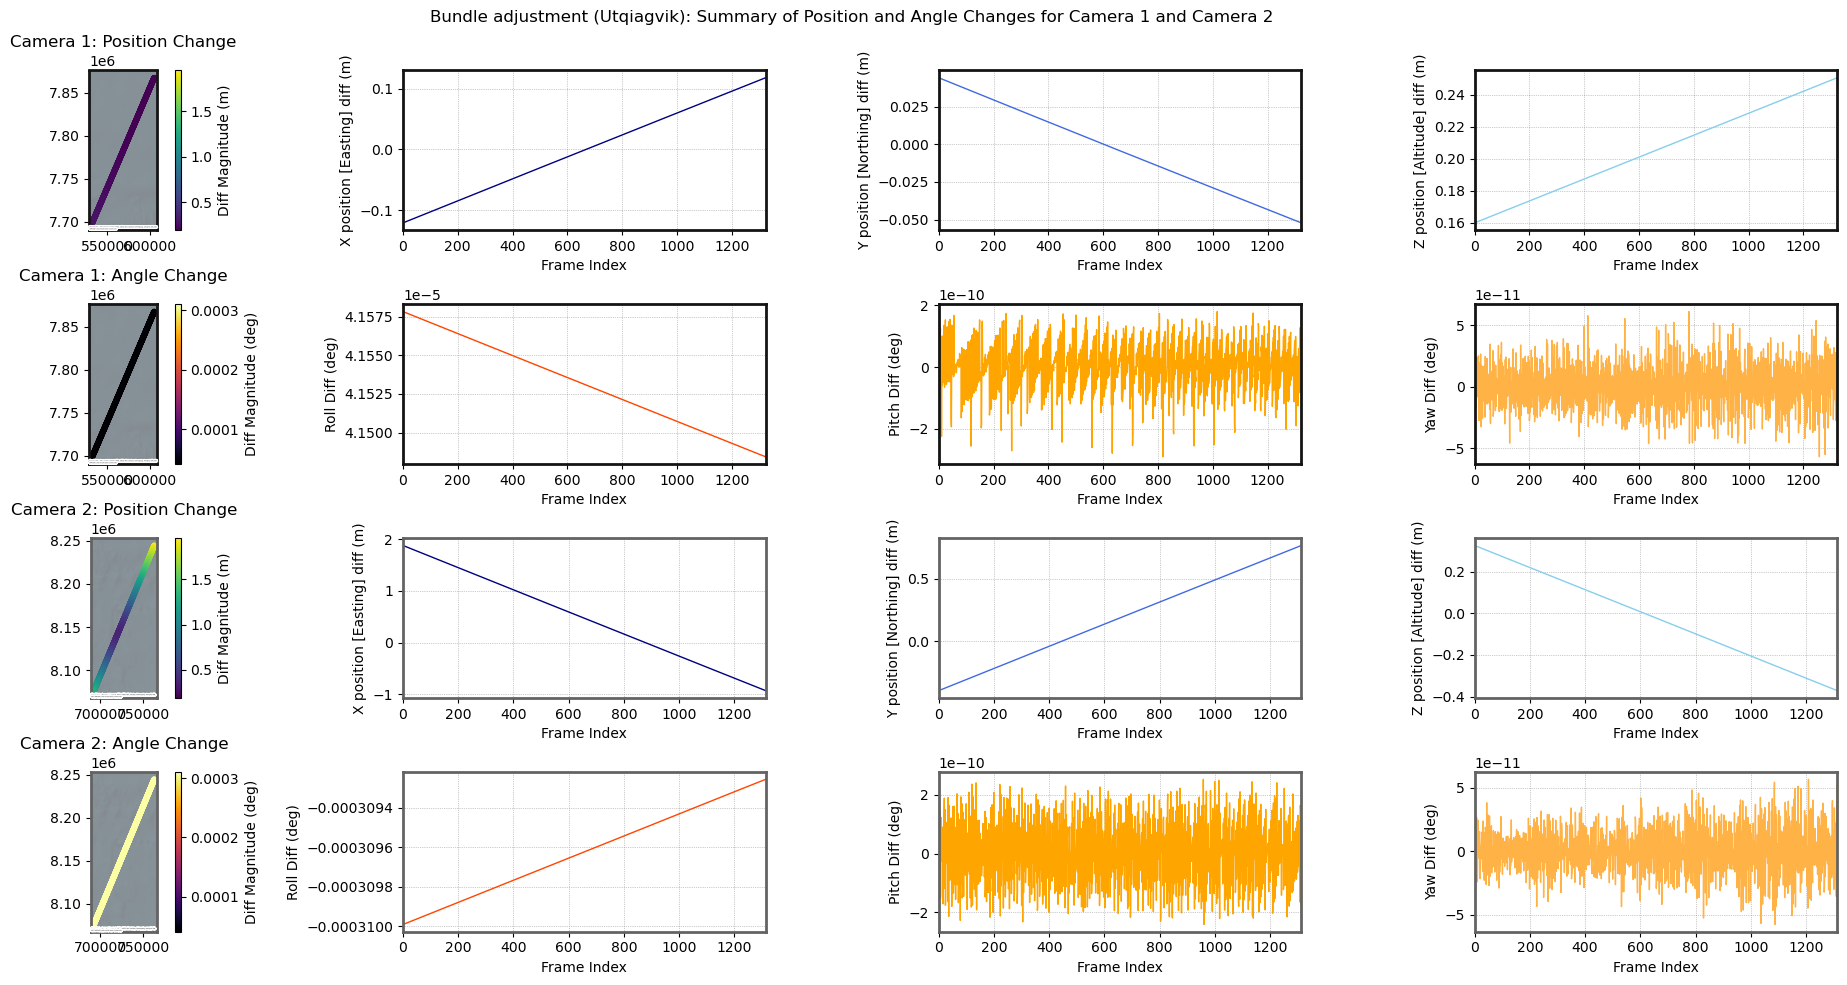

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(20, 10))

# Calculate colorbar ranges
position_values = np.concatenate([gdf_cam1.position_diff_magnitude, gdf_cam2.position_diff_magnitude])
angular_values = np.concatenate([gdf_cam1.angular_diff_magnitude, gdf_cam2.angular_diff_magnitude])

position_vmin, position_vmax = np.percentile(position_values, [0, 100])
angular_vmin, angular_vmax = np.percentile(angular_values, [0, 100])
# position_vmin, position_vmax = np.percentile(position_values, [0, 95])
# angular_vmin, angular_vmax = np.percentile(angular_values, [0, 95])

# Camera 1 mapview plot
ax = axes[0, 0]
im1 = gdf_cam1.plot(ax=ax, column="position_diff_magnitude", cmap="viridis", markersize=10, vmin=position_vmin, vmax=position_vmax, legend=False, label="Camera 1")
ax.set_title("Camera 1: Position Change")
ctx.add_basemap(ax=ax, **ctx_kwargs)
sm1 = ScalarMappable(norm=Normalize(vmin=position_vmin, vmax=position_vmax), cmap="viridis")
cbar1 = plt.colorbar(sm1, ax=ax, orientation="vertical", aspect=30, pad=0.05)
cbar1.set_label("Diff Magnitude (m)")

# Camera 1 angular mapview plot
ax = axes[1, 0]
im3 = gdf_cam1.plot(ax=ax, column="angular_diff_magnitude", cmap="inferno", markersize=10, vmin=angular_vmin, vmax=angular_vmax, legend=False, label="Camera 1")
ax.set_title("Camera 1: Angle Change")
ctx.add_basemap(ax=ax, **ctx_kwargs)
sm3 = ScalarMappable(norm=Normalize(vmin=angular_vmin, vmax=angular_vmax), cmap="inferno")
cbar3 = plt.colorbar(sm3, ax=ax, orientation="vertical", aspect=30, pad=0.05)
cbar3.set_label("Diff Magnitude (deg)")

frame_cam1 = np.arange(gdf_cam1.shape[0])

# Plot diffs in x, y, z for Camera 1
ax1 = axes[0, 1]
ax1.plot(frame_cam1, gdf_cam1.x_position_diff, c="#000080", lw=1)
ax1.set_xlabel("Frame Index")
ax1.set_ylabel("X position [Easting] diff (m)")

ax2 = axes[0, 2]
ax2.plot(frame_cam1, gdf_cam1.y_position_diff, c="#4169E1", lw=1)
ax2.set_xlabel("Frame Index")
ax2.set_ylabel("Y position [Northing] diff (m)")

ax3 = axes[0, 3]
ax3.plot(frame_cam1, gdf_cam1.z_position_diff, c="#87CEEB", lw=1)
ax3.set_xlabel("Frame Index")
ax3.set_ylabel("Z position [Altitude] diff (m)")

# Share y-axis for position diff plots
min_val = min(gdf_cam1.x_position_diff.min(), gdf_cam1.y_position_diff.min(), gdf_cam1.z_position_diff.min())
max_val = max(gdf_cam1.x_position_diff.max(), gdf_cam1.y_position_diff.max(), gdf_cam1.z_position_diff.max())

# ax1.set_ylim(min_val, max_val)
# ax2.set_ylim(min_val, max_val)
# ax3.set_ylim(min_val, max_val)
# ax1.set_yscale('symlog')
# ax2.set_yscale('symlog')
# ax3.set_yscale('symlog')
ax1.set_xlim(frame_cam1.min(), frame_cam1.max())
ax2.set_xlim(frame_cam1.min(), frame_cam1.max())
ax3.set_xlim(frame_cam1.min(), frame_cam1.max())
ax1.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax2.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax3.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")

# Plot diffs in roll, pitch, yaw for Camera 1
ax1 = axes[1, 1]
ax1.plot(frame_cam1, gdf_cam1.roll_diff, c="#FF4500", lw=1)
ax1.set_xlabel("Frame Index")
ax1.set_ylabel("Roll Diff (deg)")

ax2 = axes[1, 2]
ax2.plot(frame_cam1, gdf_cam1.pitch_diff, c="#FFA500", lw=1)
ax2.set_xlabel("Frame Index")
ax2.set_ylabel("Pitch Diff (deg)")

ax3 = axes[1, 3]
ax3.plot(frame_cam1, gdf_cam1.yaw_diff, c="#FFB347", lw=1)
ax3.set_xlabel("Frame Index")
ax3.set_ylabel("Yaw Diff (deg)")

# Share y-axis for angular diff plots
min_val = min(gdf_cam1.roll_diff.min(), gdf_cam1.pitch_diff.min(), gdf_cam1.yaw_diff.min())
max_val = max(gdf_cam1.roll_diff.max(), gdf_cam1.pitch_diff.max(), gdf_cam1.yaw_diff.max())

# ax1.set_ylim(min_val, max_val)
# ax2.set_ylim(min_val, max_val)
# ax3.set_ylim(min_val, max_val)
# ax1.set_yscale('symlog')
# ax2.set_yscale('symlog')
# ax3.set_yscale('symlog')
ax1.set_xlim(frame_cam1.min(), frame_cam1.max())
ax2.set_xlim(frame_cam1.min(), frame_cam1.max())
ax3.set_xlim(frame_cam1.min(), frame_cam1.max())
ax1.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax2.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax3.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")


# Camera 2 mapview plot
ax = axes[2, 0]
im2 = gdf_cam2.plot(ax=ax, column="position_diff_magnitude", cmap="viridis", markersize=10, vmin=position_vmin, vmax=position_vmax, legend=False, label="Camera 2")
ax.set_title("Camera 2: Position Change")
ctx.add_basemap(ax=ax, **ctx_kwargs)
sm2 = ScalarMappable(norm=Normalize(vmin=position_vmin, vmax=position_vmax), cmap="viridis")
cbar2 = plt.colorbar(sm2, ax=ax, orientation="vertical", aspect=30, pad=0.05)
cbar2.set_label("Diff Magnitude (m)")

# Camera 2 angular mapview plot
ax = axes[3, 0]
im4 = gdf_cam2.plot(ax=ax, column="angular_diff_magnitude", cmap="inferno", markersize=10, vmin=angular_vmin, vmax=angular_vmax, legend=False, label="Camera 2")
ax.set_title("Camera 2: Angle Change")
ctx.add_basemap(ax=ax, **ctx_kwargs)
sm4 = ScalarMappable(norm=Normalize(vmin=angular_vmin, vmax=angular_vmax), cmap="inferno")
cbar4 = plt.colorbar(sm4, ax=ax, orientation="vertical", aspect=30, pad=0.05)
cbar4.set_label("Diff Magnitude (deg)")

frame_cam2 = np.arange(gdf_cam2.shape[0])

# Plot diffs in x, y, z for Camera 2
ax1 = axes[2, 1]
ax1.plot(frame_cam2, gdf_cam2.x_position_diff, c="#000080", lw=1)
ax1.set_xlabel("Frame Index")
ax1.set_ylabel("X position [Easting] diff (m)")

ax2 = axes[2, 2]
ax2.plot(frame_cam2, gdf_cam2.y_position_diff, c="#4169E1", lw=1)
ax2.set_xlabel("Frame Index")
ax2.set_ylabel("Y position [Northing] diff (m)")

ax3 = axes[2, 3]
ax3.plot(frame_cam2, gdf_cam2.z_position_diff, c="#87CEEB", lw=1)
ax3.set_xlabel("Frame Index")
ax3.set_ylabel("Z position [Altitude] diff (m)")

# Share y-axis for position diff plots
min_val = min(gdf_cam2.x_position_diff.min(), gdf_cam2.y_position_diff.min(), gdf_cam2.z_position_diff.min())
max_val = max(gdf_cam2.x_position_diff.max(), gdf_cam2.y_position_diff.max(), gdf_cam2.z_position_diff.max())

# ax1.set_ylim(min_val, max_val)
# ax2.set_ylim(min_val, max_val)
# ax3.set_ylim(min_val, max_val)
# ax1.set_yscale('symlog')
# ax2.set_yscale('symlog')
# ax3.set_yscale('symlog')
ax1.set_xlim(frame_cam2.min(), frame_cam2.max())
ax2.set_xlim(frame_cam2.min(), frame_cam2.max())
ax3.set_xlim(frame_cam2.min(), frame_cam2.max())
ax1.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax2.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax3.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")

# Plot diffs in roll, pitch, yaw for Camera 2
ax1 = axes[3, 1]
ax1.plot(frame_cam2, gdf_cam2.roll_diff, c="#FF4500", lw=1)
ax1.set_xlabel("Frame Index")
ax1.set_ylabel("Roll Diff (deg)")

ax2 = axes[3, 2]
ax2.plot(frame_cam2, gdf_cam2.pitch_diff, c="#FFA500", lw=1)
ax2.set_xlabel("Frame Index")
ax2.set_ylabel("Pitch Diff (deg)")

ax3 = axes[3, 3]
ax3.plot(frame_cam2, gdf_cam2.yaw_diff, c="#FFB347", lw=1)
ax3.set_xlabel("Frame Index")
ax3.set_ylabel("Yaw Diff (deg)")

# Share y-axis for angular diff plots
min_val = min(gdf_cam2.roll_diff.min(), gdf_cam2.pitch_diff.min(), gdf_cam2.yaw_diff.min())
max_val = max(gdf_cam2.roll_diff.max(), gdf_cam2.pitch_diff.max(), gdf_cam2.yaw_diff.max())

# ax1.set_ylim(min_val, max_val)
# ax2.set_ylim(min_val, max_val)
# ax3.set_ylim(min_val, max_val)
# ax1.set_yscale('symlog')
# ax2.set_yscale('symlog')
# ax3.set_yscale('symlog')
ax1.set_xlim(frame_cam2.min(), frame_cam2.max())
ax2.set_xlim(frame_cam2.min(), frame_cam2.max())
ax3.set_xlim(frame_cam2.min(), frame_cam2.max())
ax1.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax2.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")
ax3.grid(True, linestyle=":", linewidth=0.5, alpha=0.8, color="gray")

for ax in axes[:2].flatten():
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('#141414')

for ax in axes[2:].flatten():
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('#636363')

fig.suptitle(f"{title}: Summary of Position and Angle Changes for Camera 1 and Camera 2")

plt.tight_layout()